In [1]:
import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import re
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import json
import sys
sys.path.append('..')
import folium
print (folium.__file__)
print (folium.__version__)

from util import check_week_ind
from util import time_interval

C:\Anaconda\lib\site-packages\folium-0.2.0-py2.7.egg\folium\__init__.pyc
0.2.0


In [3]:
#read data 
data = pd.read_csv('201408_trip_data.csv')

In [4]:
#data process 
#Start Date from the csv file is string type instead of timestamp 
for col in ('Start Date', 'End Date'):
    data[col] = pd.to_datetime(data[col])
    
#extract Month and Hour 
data['Month'] = data['Start Date'].map(lambda x: x.month)
data['Day'] = data['Start Date'].map(lambda x: x.day)
data['Hour']  = data['Start Date'].map(lambda x: x.hour)
data['Minute'] = data['Start Date'].map(lambda x: x.minute)
data['End_Month'] = data['End Date'].map(lambda x: x.month)
data['End_Hour']  = data['End Date'].map(lambda x: x.hour)
data['End_Minute'] = data['End Date'].map(lambda x: x.minute)
data['Route'] = data['Start Terminal'].apply(str) + 'to' + data['End Terminal'].apply(str)
data['Num_Bike_Used'] = 1

In [6]:
#process time using package timeprocess
data['Day_Of_Week'] = data['Start Date'].map(lambda x: x.isoweekday())
data['Week_Ind'] = data['Day_Of_Week'].map(lambda x: check_week_ind(x))
data['Minute_Interval'] = data['Minute'].map(lambda x: time_interval(x))
data['End_Minute_Interval'] = data['End_Minute'].map(lambda x: time_interval(x))

In [7]:
#average hourly bike # across a day for each month
groupby1 = ['Subscriber Type', 'Month', 'Day','Week_Ind','Hour']
groupby2 = ['Subscriber Type', 'Month','Week_Ind','Hour']
#group the data to get average bike # per hour in weekdays/weekends 
group = data.groupby(groupby1).agg({'Num_Bike_Used': np.sum}).reset_index()
data_grouped = group.groupby(groupby1).agg({'Num_Bike_Used': np.mean}).reset_index()
data_grouped.rename(columns ={'Num_Bike_Used': 'AVG_NUM_BIKE'}, inplace = True)
data_grouped.sort_values('Hour', inplace = True)

In [8]:
def timeseriesplot(table, x_col, y_col, hue_col, index, title, xlabel_title, ylabel_title, legend_title):
    """plot bike demand in different hours during a day 
       
       Args: table:   (pd dataframe)
             x_col:   hour (str)
             y_col:   total bike # in that hour (str)
             hue_col: month: march - august (str)
             index:   subplots index (int)
             title:   (str)
             xlabel_title: (str)
             ylabel_title: (str)
             legend_title: (str)
       Returns: a time series plot cross all months 
    """
    
    #timeseries plot
    sns.pointplot(x=x_col, y=y_col, hue=hue_col, data= table, ax=axs[index])
    
    #set labels 
    axs[index].set_xlabel(xlabel_title, size=20)
    axs[index].set_ylabel(ylabel_title, size = 20)
    axs[index].set_title(title, size = 25)
    #set legend 
    legend = axs[index].legend(bbox_to_anchor=(1, 1), loc=2, title = legend_title, fontsize = 15)
    legend.get_title().set_fontsize('15')
    #change x-ticks y-ticks fontsize 
    for tl in axs[index].get_yticklabels():
            tl.set_fontsize(20)
    for tl in axs[index].get_xticklabels():
            tl.set_fontsize(20)


In [180]:
%%html
<h1 style = "font-size: 30px"> Bike Allocation Optimization </h1>
<ul style="font-size:20px" margin:0 20px 20px 0>
  <li margin:30px 0>Explore Bike Demand Over Time During a Day</li>
  <li>Explore Popular Bike Stations</li>
  <li>Optimize number of bikes at each station</li>
</ul>

In [179]:
%%html
<h1 style = "font-size: 30px"> Explore Bike Demand Over Time During a Day </h1>
<ul style="font-size:20px" margin:0 20px 20px 0>
  <li>We can see high demand during rush hours during weekdays</li>
  <li>Subscribers drive the majority of total demand</li>
  <li>We can maintain and repaire bikes on weekends</li>
</ul>

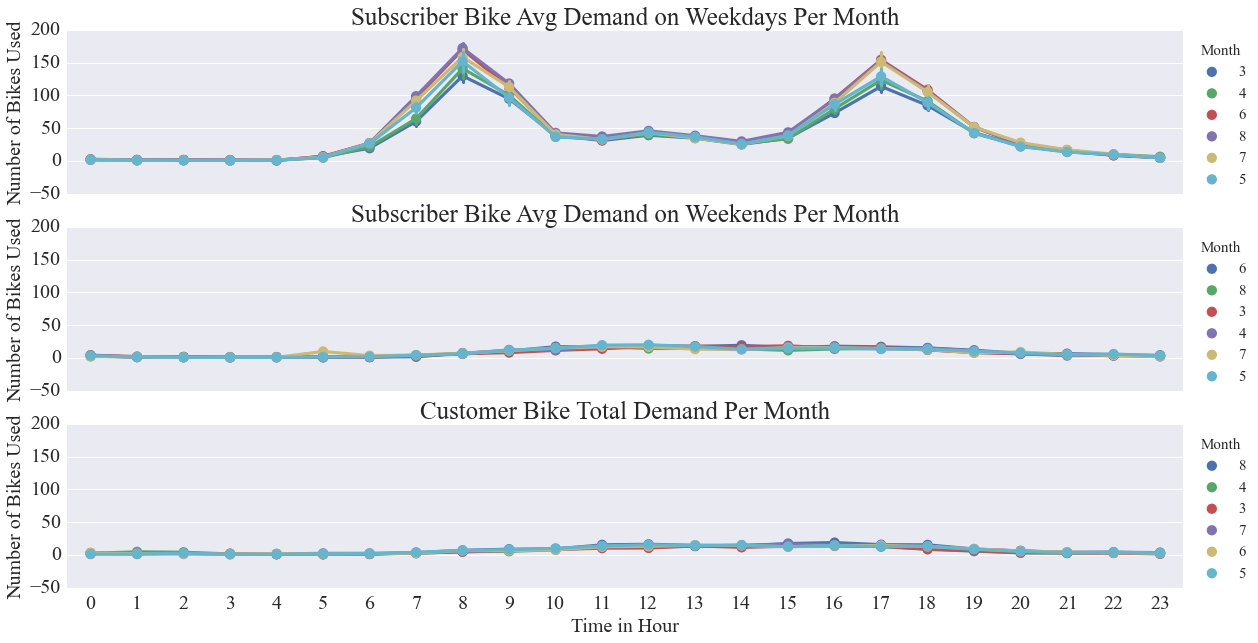

In [43]:
sns.set_style("whitegrid")
sns.set(font = 'Times New Roman')
#fig.subplots_adjust(top = 5, bottom=3)
fig, axs = plt.subplots(3,sharex = True, sharey = True, figsize=(20, 10))

data_subscriber_wkd = data_grouped[(data_grouped['Subscriber Type'] == 'Subscriber') 
                                  & (data_grouped['Week_Ind'] == 'Weekdays')]
#plot
timeseriesplot(data_subscriber_wkd,
               "Hour",
               "AVG_NUM_BIKE", 
               "Month", 
               0,
               "Subscriber Bike Avg Demand on Weekdays Per Month", 
               "  ",
              "Number of Bikes Used",
               "Month")

data_subscriber_wkn = data_grouped[(data_grouped['Subscriber Type'] == 'Subscriber') 
                                  & (data_grouped['Week_Ind'] == 'Weekends')]
#plot 
timeseriesplot(data_subscriber_wkn, 
               "Hour",
               "AVG_NUM_BIKE", 
               "Month", 
               1,
               "Subscriber Bike Avg Demand on Weekends Per Month", 
               "  ",
               "Number of Bikes Used",
               "Month")

data_customer = data_grouped[data_grouped['Subscriber Type'] == 'Customer']
#plot 
timeseriesplot(data_customer,
               "Hour",
               "AVG_NUM_BIKE",
               "Month", 
               2,
               "Customer Bike Total Demand Per Month", 
               "Time in Hour",
               "Number of Bikes Used",
               "Month")



In [43]:
#subscribers from CA 
data_sf = data[(data['Zip Code'].str.contains('94'))       #extract SF zip code   
               &(data.Hour.isin([7, 8, 9, 17, 18, 19]))    #rush hour 
               &(data['Month'] == 8)].reset_index()        #focus on August

#strip - in zip code and convert string to int in order to map with the json file 
data_sf['Zip Code'] = data_sf['Zip Code'].map(lambda x: int(x.split('-')[0]))

#calculate the average number of bikes used during rush hours in August
grouped = data_sf.groupby(['Zip Code', 'Day','Hour']).agg({'Num_Bike_Used': np.sum}).reset_index()
data_sf_mean = grouped.groupby(['Zip Code']).agg({'Num_Bike_Used': np.mean}).reset_index()
data_sf_mean.rename(columns ={'Num_Bike_Used': 'AVG_NUM_BIKE'}, inplace = True)

In [178]:
%%html
<h1 style = "font-size: 30px"> Explore Popular Bike Stations During Rush Hours </h1>
<ul style="font-size:20px" margin:0 20px 20px 0>
  <li>Assume subscribers use nearby bike stations in the morning </li>
  <li>SoMa, Financial Dsitrict and North Beach are popular districts</li>
  <li>We can re-allocate bikes from nearby less popular areas</li>
</ul>

In [185]:
#plot the map 
#average number of bikes per hour during rush hours 
m = folium.Map([43,-100], zoom_start=4)

m.choropleth(
    geo_path='sf.zip.geo2.json',
    data = data_sf_mean,
    columns = ['Zip Code', 'AVG_NUM_BIKE'],
    key_on = 'feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_weight=2,
    #legend_name='Ave Num of Bikes During Rush Hours'
    )
m

In [49]:
# boolean series we will use to select trips
in_morning = data_sf['Hour'].isin((7, 8, 9))
in_month = data_sf['Month'] == 8
in_week = data_sf['Week_Ind'] == 'Weekdays'

trips_per_station = data_sf[in_morning & in_month & in_week].groupby(['Start Station', 'Start Terminal']).count()['Trip ID']
trips_per_station.order(ascending=False).head(5)

Start Station                                  Start Terminal
San Francisco Caltrain (Townsend at 4th)       70                983
Temporary Transbay Terminal (Howard at Beale)  55                594
San Francisco Caltrain 2 (330 Townsend)        69                581
Harry Bridges Plaza (Ferry Building)           50                539
Steuart at Market                              74                363
Name: Trip ID, dtype: int64

In [11]:
def subset_data(data, month, hours, weekday):
    """Finds arrivals and departures for a given month and hours of the day
       Args: data
             terminal: station number 
             month:
             hours:
             weekday
       Returns: subset data 
    """
    # boolean series we will use to select data
    in_hours = data['Hour'].isin(hours)
    in_month = data['Month'] == month
    week_ind = data['Week_Ind'] == weekday
       
            
    return  data[in_month & in_hours & week_ind]
    #departures = data[in_month & in_hours & week_ind]

In [12]:
def data_avg(data, groupby1, groupby2, new_col):
    
    data_new = data.groupby(groupby1).agg({'Num_Bike_Used': np.sum}).reset_index()
    data_new = data_new.groupby(groupby2).agg({'Num_Bike_Used': np.mean}).reset_index()
    data_new.rename(columns ={'Num_Bike_Used': new_col}, inplace = True)
    data_new[new_col] = data_new[new_col].round()
    return data_new

In [13]:
#select data during rush hours on August 
data_rush_hour = subset_data(data, 8, [7, 8, 9, 17, 18, 19], 'Weekdays')

In [14]:
#extract average # bikes arrive in each station 
data_arrival_avg = data_avg(data_rush_hour, 
                            ['End Station', 'Day', 'Hour', 'End_Minute_Interval'], 
                            ['End Station', 'Hour', 'End_Minute_Interval'], 
                            'Avg_Num_Bike_In')
                            #['End Station', 'Hour', 'End_Minute_Interval', 'Avg_Num_Bike_In'])
    
#extract average # bikes depature in each station 
data_depature_avg = data_avg(data_rush_hour, 
                             ['Start Station', 'Day', 'Hour', 'Minute_Interval'], 
                             ['Start Station', 'Hour', 'Minute_Interval'], 
                             'Avg_Num_Bike_Out')
                             #['Start Station', 'Hour', 'Minute_Interval', 'Avg_Num_Bike_Out'])

In [46]:
#join depature and arrival by station, time interval
total_merge = data_depature_avg.merge(data_arrival_avg, 
                        left_on=['Start Station', 'Hour', 'Minute_Interval'], 
                        right_on=['End Station', 'Hour', 'End_Minute_Interval'], how='left').reset_index()

#extract related data 
total_merge = total_merge[['Start Station', 'Hour', 'Minute_Interval', 'Avg_Num_Bike_Out','Avg_Num_Bike_In']]
total_merge['Time'] = total_merge['Hour'].apply(str) + ':' + total_merge['Minute_Interval'].apply(str)
total_merge['Available'] = None #intialize
total_merge['Avg_Num_Bike_Out'].fillna(0, inplace=True)
total_merge['Avg_Num_Bike_In'].fillna(0, inplace=True )
total_merge['Diff'] = total_merge['Avg_Num_Bike_In'] -  total_merge['Avg_Num_Bike_Out']

In [59]:
def optimize_bike(table, initial):
    """Given a table with arrive number & depature number & initial bikes 
       Args: table
             initital: int (#bikes in the station)
       Returns: # of bikes available at each time interval 
    """
    table['Initial'] = initial
    
#     for i in range(table.shape[0]):
#         initial =  initial +  table['Avg_Num_Bike_In'][i] - table['Avg_Num_Bike_Out'][i]
#         table['Available'].loc[i] = initial
    table['Available'] = table['Diff'].cumsum()+initial
        
    return table

In [72]:
def available_bikes(start, step, n, table_pass):
    """Pass different initial bikes and calculate avaiable bikes
       Args: start: initial bike (int)
             step: step to increase initial bikes (int)
             n: iteration numbers (int)
             table_pass: table used to calculate available bikes
       Returns: a table with available bikes in each time interval 
    """
    initial_table = pd.DataFrame()
    for i in range(n): 
        initial = start + i*step
        initial_table = initial_table.append(optimize_bike(table_pass, initial))
        
    return initial_table

In [60]:
caltrain_4th = total_merge[(total_merge['Start Station'] == 'San Francisco Caltrain (Townsend at 4th)')
                           &(total_merge['Hour'].isin([7, 8, 9]))].reset_index()

caltrain_4th_combine = available_bikes(20, 5, 3, caltrain_4th)

In [ ]:
##################the same apply for the second ###################################

In [75]:
TTT = total_merge[(total_merge['Start Station'] == 'Temporary Transbay Terminal (Howard at Beale)')
                  &(total_merge['Hour'].isin([7, 8, 9]))].reset_index()

TTT_combine = available_bikes(10, 5, 3, TTT)

In [181]:
%%html
<h1 style = "font-size: 30px"> Optimize Bike Numbers During Rush Hours</h1>
<ul style="font-size:20px" margin:0 20px 20px 0>
  <li>Choose top 2 high demand stations</li>
  <li>Calculate numbers of arrivals and number of departures in each time interval</li>
  <li>Pick different initial bike numbers in the station</li>
  <li>Calculate available bikes in each time interval</li>
</ul>

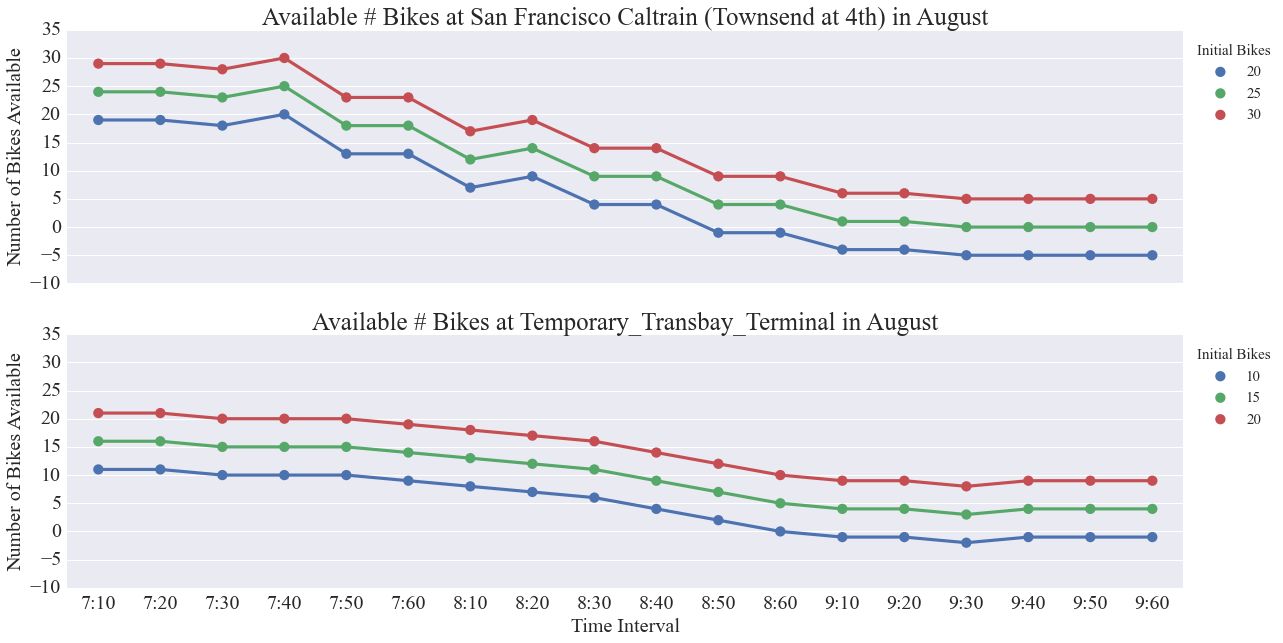

In [76]:
sns.set_style("darkgrid")
sns.set(font = 'Times New Roman')
#fig.subplots_adjust(top = 5, bottom=3)
fig, axs = plt.subplots(2,sharex = True, sharey = True, figsize=(20, 10))

#plot
timeseriesplot(caltrain_4th_combine,
               "Time",
               "Available", 
               "Initial", 
               0,
               "Available # Bikes at San Francisco Caltrain (Townsend at 4th) in August", 
               "  ",
               "Number of Bikes Available",
                "Initial Bikes")


timeseriesplot(TTT_combine,
               "Time",
               "Available", 
               "Initial", 
               1,
               "Available # Bikes at Temporary_Transbay_Terminal in August", 
               "Time Interval",
               "Number of Bikes Available",
                "Initial Bikes")

In [65]:
#first popular station 
caltrain_4th_pm = total_merge[(total_merge['Start Station'] == 'San Francisco Caltrain (Townsend at 4th)')
                              &(total_merge['Hour'].isin([17, 18, 19]))].reset_index()

caltrain_4th_combine_pm = available_bikes(0, 5, 3, caltrain_4th_pm)

In [78]:
#second popular station 
townsend7_pm = total_merge[(total_merge['Start Station'] == 'Townsend at 7th')
                           &(total_merge['Hour'].isin([17, 18, 19]))].reset_index()

townsend7_combine_pm = available_bikes(10, 5, 3, townsend7_pm)

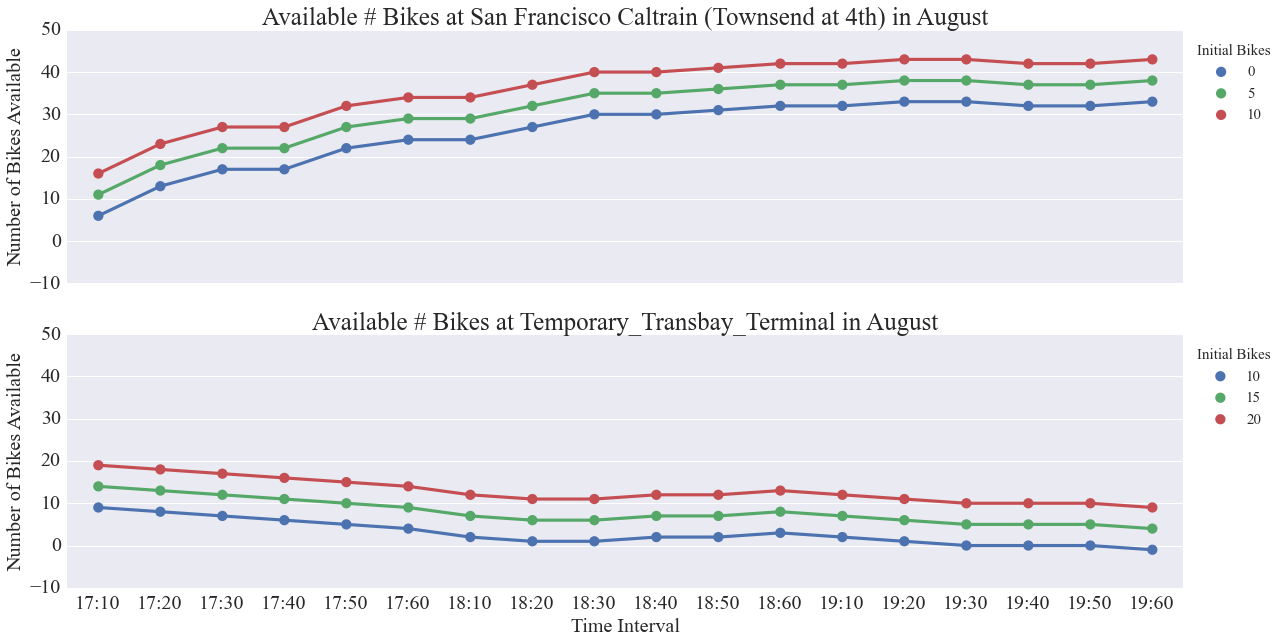

In [79]:
sns.set_style("darkgrid")
sns.set(font = 'Times New Roman')
#fig.subplots_adjust(top = 5, bottom=3)
fig, axs = plt.subplots(2,sharex = True, sharey = True, figsize=(20, 10))

#plot
timeseriesplot(caltrain_4th_combine_pm,
               "Time",
               "Available", 
               "Initial", 
               0,
               "Available # Bikes at San Francisco Caltrain (Townsend at 4th) in August", 
               "  ",
               "Number of Bikes Available",
                "Initial Bikes")


timeseriesplot(townsend7_combine_pm,
               "Time",
               "Available", 
               "Initial", 
               1,
               "Available # Bikes at Temporary_Transbay_Terminal in August", 
               "Time Interval",
               "Number of Bikes Available",
                "Initial Bikes")

In [80]:
%%html
<h1 style = "font-size: 30px">Insights</h1>
<ul style="font-size:20px" margin:0 20px 20px 0>
  <li>Provide promotions to encourage people to use bikes from 11:00 am to 3:00 pm</li>
  <li>Maintain and repair bikes on weekends</li>
  <li>Re-allocate bikes from less popular areas to more popular areas during rush hours</li>
  <li>Provide initial bike numbers so that there are always extra bikes available in the morning</li>
  <li>Refill bike stations around 9 a.m. </li>
  <li>During the evening rush hours, we need to remove extra bikes to ensure enough spots to lock bikes</li>
</ul>